# Stationarity

Stationarity is an important concept in time series analysis. Loosely speaking, it means that the statistical properties of the time series, such as mean, variance, and covariance, does not change with time.

Many analyses assumes that the time series is stationary, hence if it is not, the analysis simply becomes inaccurate. Here is an example.

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller, kpss
import statsmodels.tsa.api as smt
from IPython.display import display, Markdown, HTML

N = 200
WSCALE = 0.001
MAXLAGS = 100

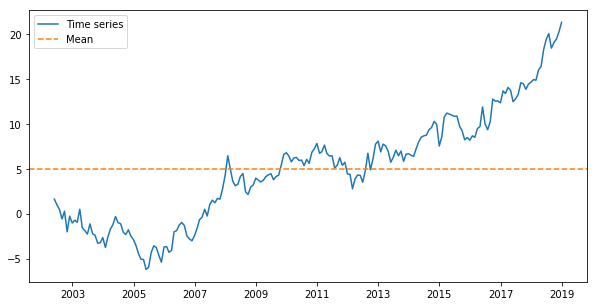

In [253]:
np.random.seed(1)
plt.figure(figsize=(10,5))
x = pd.date_range(end='2019-01-01', periods=N, freq='M')
y = np.random.normal(scale=1, size=N).cumsum()
plt.plot(x, y, label='Time series')
plt.axhline(y.mean(), label='Mean', linestyle='--', color='C1')
_ = plt.legend()


The above chart shows an example of time series data from year 2003 to 2019. The data is just a random walk, but that's not important. Also shown is the mean of the time series.

We can easily imagine that if we use that mean in year 2019, that value is inaccurate. This is because the mean is not constant throughout the time for this particular time series (we can see that it is mostly trending up). Hence we can say this time series is not stationary. And indeed a random walk is not stationary, as we'll see later.

## Types of Stationarity

The two main types of stationarity are weak stationarity and strong stationarity. But there are other classifications as well.

References:
- [Can a time series be stationary if the formula for the mean level depends on  t ?
](https://stats.stackexchange.com/a/174747)

### Weak Stationarity

Also known as **wide stationarity**, **covariance stationarity**, or **second-order stationarity**, is when mean, variance and covariances are constant throughout time, ie.:
- $\mathbb{E}[X_t] = \mu$ is independent of $t$, ie. the mean is constant over time. This requirement is also called **first order stationarity**
- $\sigma^2(t) = \mathbb{E}[(x_t - \mu(t))^2] = \sigma^2$, ie. variance is constant over time,
- $\operatorname{Cov}(X_{t+h},X_t)$ is independent of $t$ for each $h$, ie. the autocovariance at each lag $h$ is constant over time.

### Strong Stationarity

Also called **strict stationarity**, requires the joint distribution function of the joint distribution of $X_t$ taken at any $k$ times $t_1, t_2, \dots , t_k$ is the same when lagged by any $\tau$. Technically, for any $k$ and any $\tau$, and for any $t_1, t_2, \dots, t_k$ we require

$$\large F_X(x_{t_1+\tau}, \dots, x_{t_k+\tau}) = F_X(x_{t_1}, \dots, x_{t_k})$$

This does not just imply that the mean and covariance at any given lag (if either exists) must stay constant over time, but that *every conceivable property one can derive from the distribution is invariant under a time shift*, in which sense its conditions are "stricter" (though note that if mean or covariance are not finite, we can have a strongly stationary series which does not fulfil the preliminary condition for weak stationarity).

Second order stationarity is weaker than strict stationarity, but one is not superset of the other. See [If a time series is second order stationary, does this imply it is strictly stationary?](https://stats.stackexchange.com/a/119857).

### Other Classifications

These are other types of stationarity that are often attributed to a time series. They are not stationary by the above definitions, but nevertheless people often classify time series this way.

#### Trend Stationarity

$X_t$ is [trend stationary](https://en.wikipedia.org/wiki/Trend_stationary) if we can express it as

$$\large X_t = f(t) + Y_t$$

where $f$ is a deterministic function of time $t$ and $\{Y_t\}$ is a stationary process.

#### Difference Stationary

This is when the time series becomes stationary after taking the first difference. An example is random walk with drift.


## Testing for Stationarity in Python

[Dickey–Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) is often used to test for stationarity in Python. However, this actually is not strictly correct. The Dickey–Fuller test tests the null hypothesis that a [unit root](https://en.wikipedia.org/wiki/Unit_root) is present in an autoregressive model. If a unit root is present, then the time series is not stationary indeed. But if a unit root is not present, that doesn't mean that the time series is stationary! The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or **trend-stationarity**.

The [Augmented Dickey–Fuller (ADF) test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) tests for unit root in higher order equations.

As we'll see later, if we use ADF test in Python to test for stationarity, it will conclude that a sine wave (with noise) is stationary, even when it's not.


## Other Interesting Things

- [Difference between series with drift and series with trend](https://stats.stackexchange.com/q/104215)

# Let's See Some Samples

In [240]:
def staplot(name, y, figsize=(15, 6), lags=MAXLAGS, style='bmh', ylim=None, useKpss=False):
    CRIT = 0.01
    adres = adfuller(y)
    
    df = pd.DataFrame()
    pval = adres[1]
    df.loc['AdFuller', 'Decision'] = decision = 'Stationary' if pval < CRIT else 'NOT Stationary'
    df.loc['AdFuller', 'Reason'] = 'pvalue: %.4f' % pval
    
    tval = adres[0]
    tlim = adres[4]['%d%%' % (CRIT / 0.01)]
    trel = '<' if tval < tlim else '>='
    df.loc['AdFuller t-value', 'Decision'] = 'Stationary' if tval < tlim else 'NOT Stationary'
    df.loc['AdFuller t-value', 'Reason'] = 'tvalue %.1f %s %.1f' % (tval, trel, tlim)
    
    if useKpss:
        kres = kpss(y, regression='c')
        pval = kres[1]
        df.loc['KPSS', 'Decision'] = 'NOT Stationary' if pval < CRIT else 'Stationary'
        df.loc['KPSS', 'Reason'] = 'pvalue: %.4f' % pval

        if df.loc['AdFuller', 'Decision'] == 'Stationary':
            if df.loc['KPSS', 'Decision'] == 'Stationary':
                decision = 'Stationary'
            else:
                decision = 'Difference Stationary'
        else:
            if df.loc['KPSS', 'Decision'] == 'Stationary':
                decision = 'Trend Stationary'
            else:
                decision = 'NOT Stationary'
        
    display(HTML(df.to_html()))        
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
        #pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        ts_ax.plot(y, label=name, color='C0')
        ts_ax.set_title('%s: %s' %  (name, decision))
        if ylim: ts_ax.set_ylim(ylim)
        ts_ax.legend()

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        #smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        
        plt.tight_layout()

## White Noise

White noises with different scales and means.

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -14.4 < -3.5


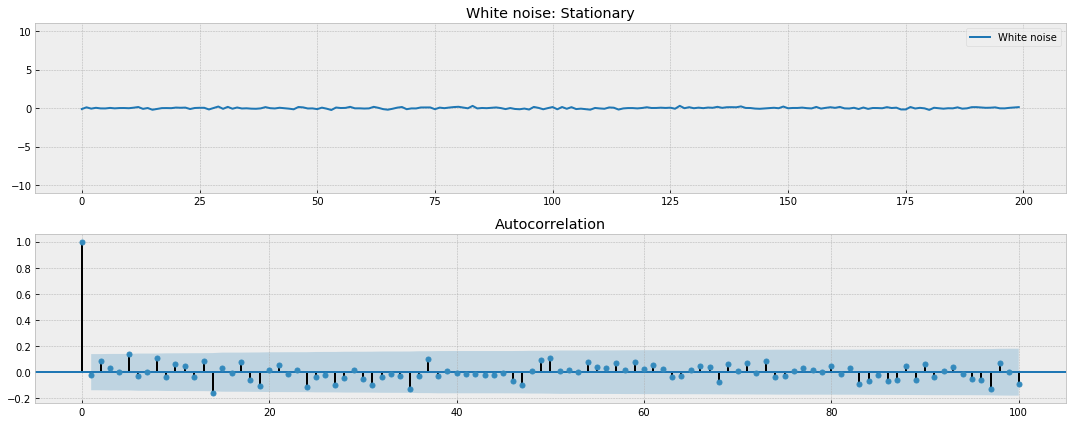

In [241]:
y = np.random.normal(scale=0.1, size=N)
staplot('White noise', y, ylim=[-11, 11])

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -14.7 < -3.5


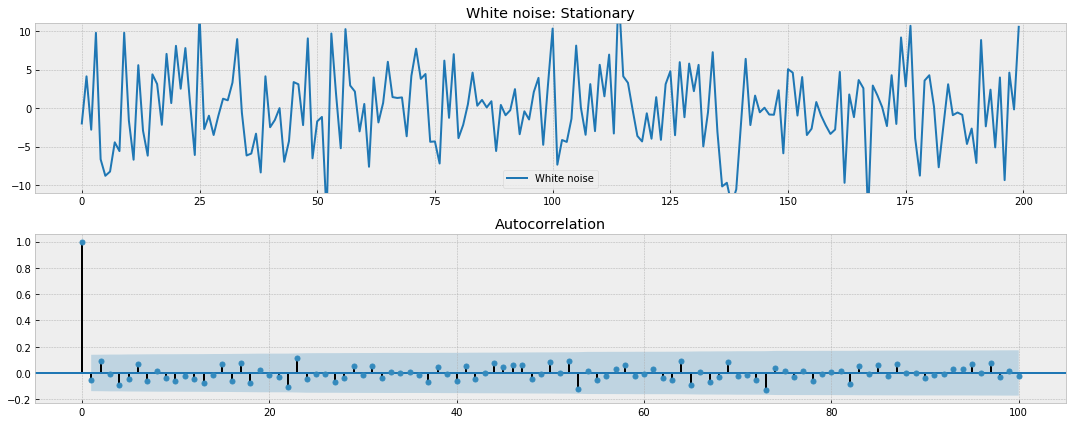

In [254]:
y = np.random.normal(scale=5, size=N)
staplot('White noise', y, ylim=[-11, 11])

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -13.2 < -3.5


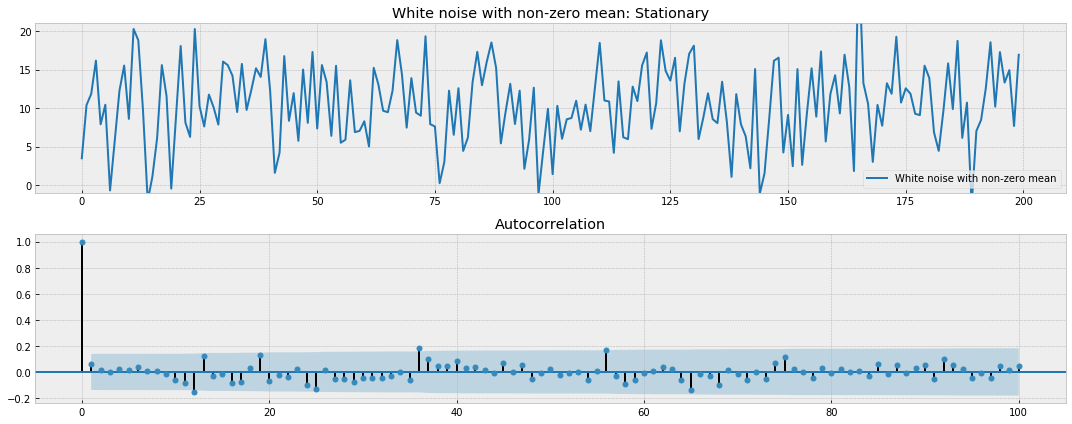

In [255]:
y = 10 + np.random.normal(scale=5, size=N)
staplot('White noise with non-zero mean', y, ylim=[-1, 21])

White noise is stationary, as expected.

## Lines

In [172]:
def generateLine(n=N, slope=1, wscale=WSCALE):
    w = np.random.normal(scale=wscale, size=n)
    if slope:
        return np.arange(0, n*slope, slope) + w
    else:
        return w

### Line

,Decision,Reason
AdFuller,NOT Stationary,pvalue: 0.9700
AdFuller t-value,NOT Stationary,tvalue 0.2 >= -3.5


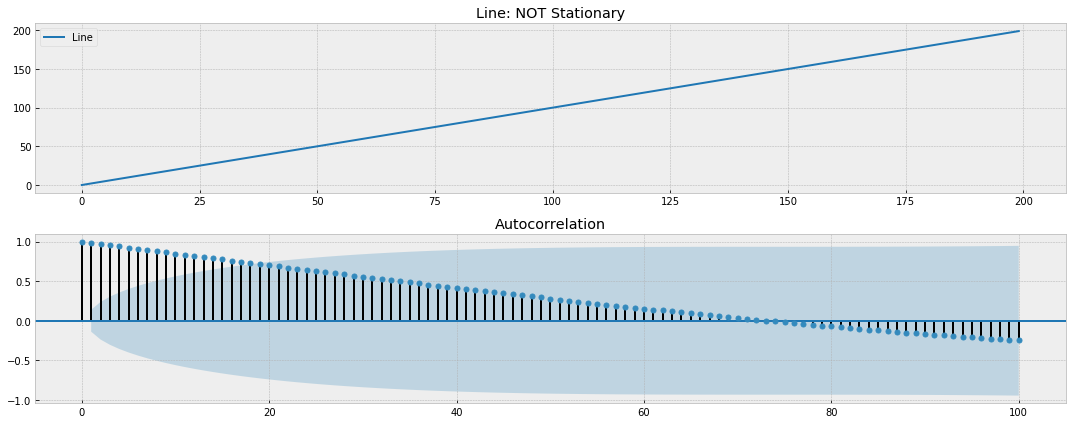

In [256]:
y = generateLine()
staplot('Line', y)

A line is not stationary, as expected, because the mean is not constant.

### Horizontal Line

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -14.4 < -3.5


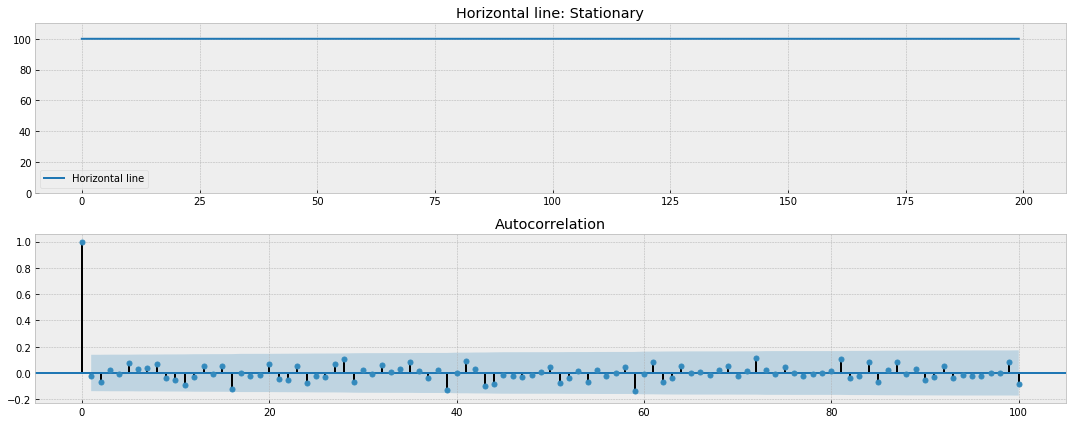

In [257]:
y = 100 + generateLine(slope=0)
staplot('Horizontal line', y, ylim=[0,110])

A horizontal line is stationary as expected.

### Noise with Drift

,Decision,Reason
AdFuller,NOT Stationary,pvalue: 0.6033
AdFuller t-value,NOT Stationary,tvalue -1.4 >= -3.5


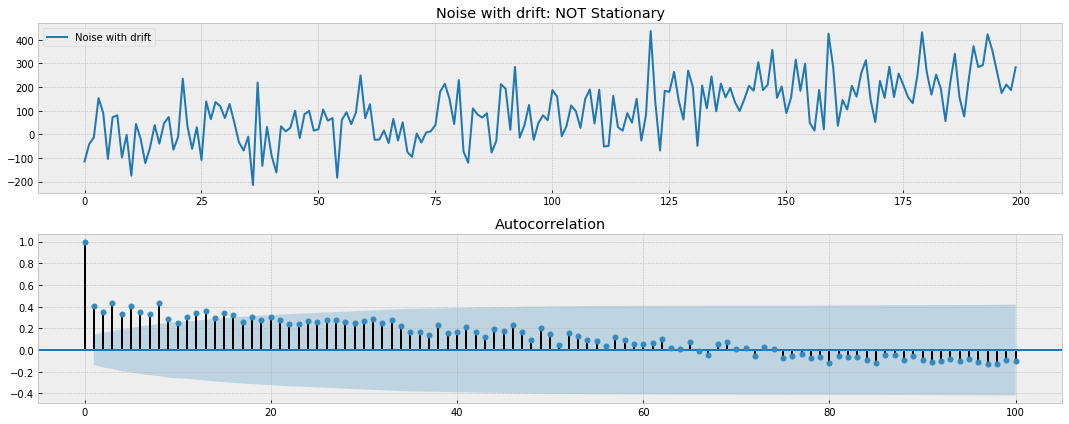

In [288]:
y = generateLine(slope=1, wscale=100)
staplot('Noise with drift', y)

As expected, noise is NOT stationary if the mean is not constant.

## Random Walk

In [261]:
def generateRandomWalk(n=N, seed=1):
    np.random.seed(seed)

    x = w = np.random.normal(scale=1, size=n)
    for t in range(n):
        x[t] = x[t-1] + w[t]
    return x

,Decision,Reason
AdFuller,NOT Stationary,pvalue: 0.9965
AdFuller t-value,NOT Stationary,tvalue 1.3 >= -3.5


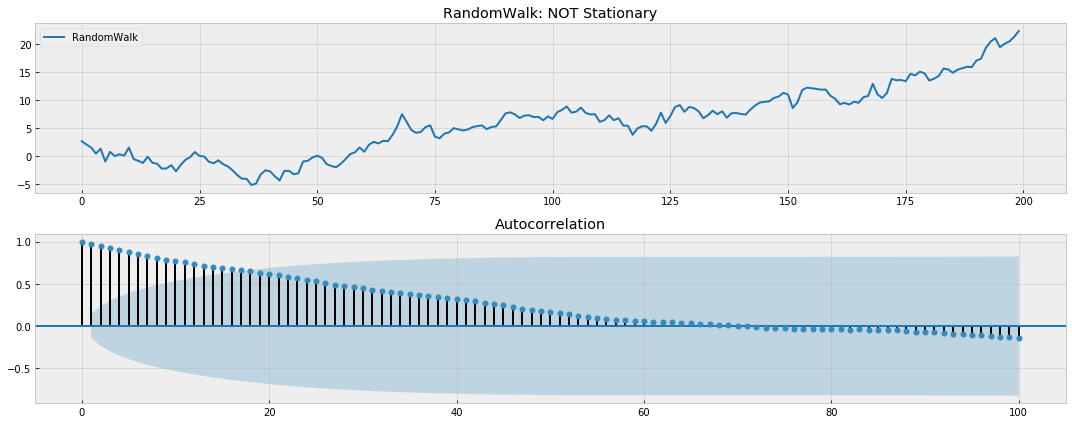

In [275]:
y = generateRandomWalk(seed=1)
staplot('RandomWalk', y)

So a random walk is not stationary, as we stated earlier. The reason is because the variance get bigger with time.

## AR(1) Process <a name="ar1">

An AR(1) (read as auto regressive of order 1) process is defined as:

$$ \large y_t = \rho y_{t-1} + \epsilon_t $$

For AR(1) to be stationary, $|\rho|$ must be < 1. If $\rho$ is 1, then the process becomes a random walk! If $\rho$ is 0, the process is white noise.

If $\rho$ is > 0, the process is trend following. If $\rho$ is < 0, the process is mean reverting.

In [263]:
def generateAR1(rho, n=N, seed=1):
    np.random.seed(seed)

    y = w = np.random.normal(scale=1, size=n)
    for t in range(n):
        y[t] = rho * y[t-1] + w[t]
    return y

### ρ = 0.9

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0034
AdFuller t-value,Stationary,tvalue -3.8 < -3.5


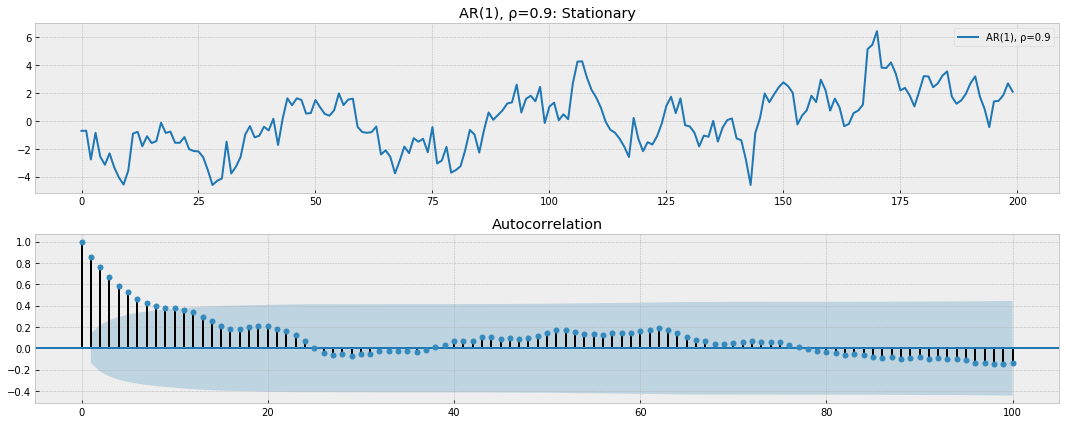

In [285]:
rho = 0.9
y = generateAR1(rho, seed=2)
staplot('AR(1), ρ=%.1f' % rho, y)

### ρ = -0.9

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -9.7 < -3.5


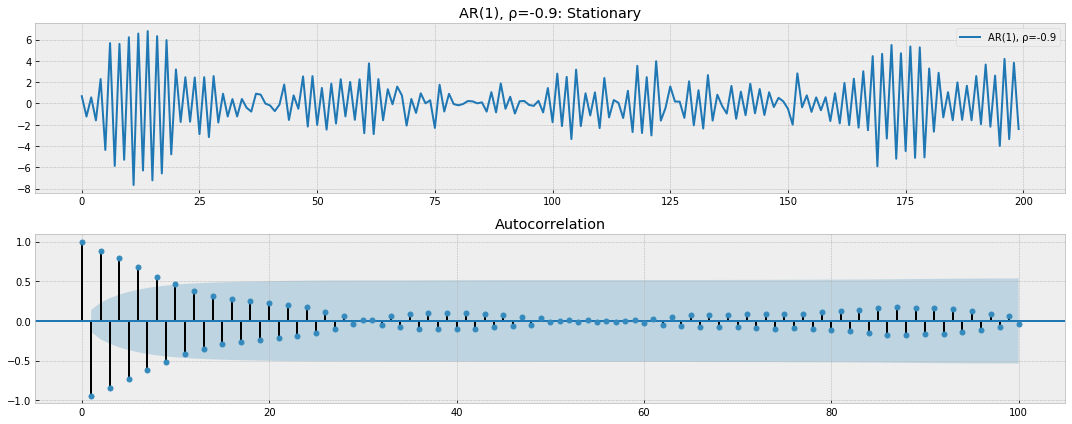

In [278]:
rho = -0.9
y = generateAR1(rho, seed=1)
staplot('AR(1), ρ=%.1f' % rho, y)

## MA(1) Process

An MA(1) (moving average of order 1) process is formally defined as:

$$\large Y_t = \mu + \epsilon_t + \theta \epsilon_{t-1}$$

If $\theta$ is 0, then the process is white noise.

The MA process is stationary for all $\theta$.

In [279]:
def generateMA(theta, n=N, mu=0, seed=1):
    np.random.seed(seed)

    y = w = np.random.normal(scale=1, size=n)
    y[0] = mu
    for t in range(1, n):
        y[t] = mu + w[t] + theta * w[t-1]
    return y    

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0028
AdFuller t-value,Stationary,tvalue -3.8 < -3.5


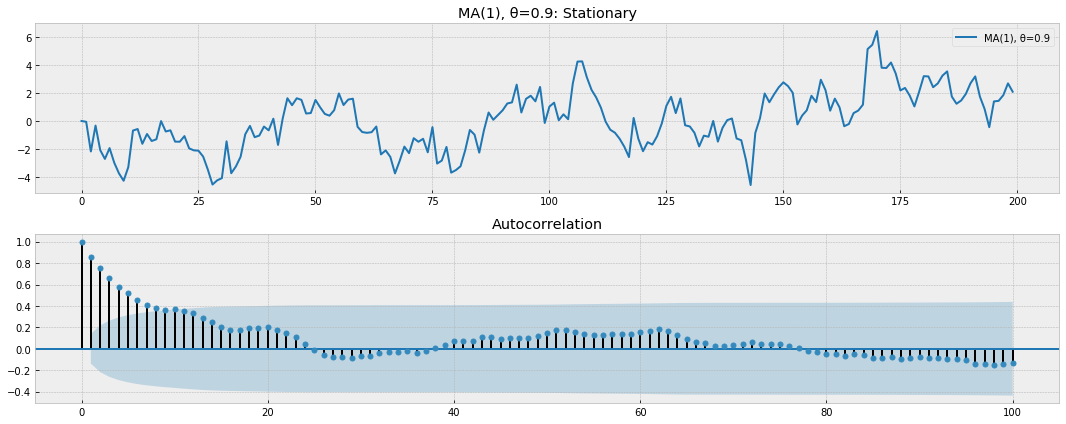

In [287]:
theta = 0.9
y = generateMA(theta, seed=2)
staplot('MA(1), θ=%.1f' % theta, y)

## Sine Waves

In [259]:
def generateSine(n=N, numPeriods=1, startPeriod=0, scale=1, wscale=WSCALE):
    period = n / numPeriods
    x = np.arange(startPeriod, startPeriod+2*np.pi*numPeriods, 2*np.pi/period)
    w = np.random.normal(scale=wscale, size=n)
    return scale * np.sin(x) + w

### Full Period

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -9.6 < -3.5


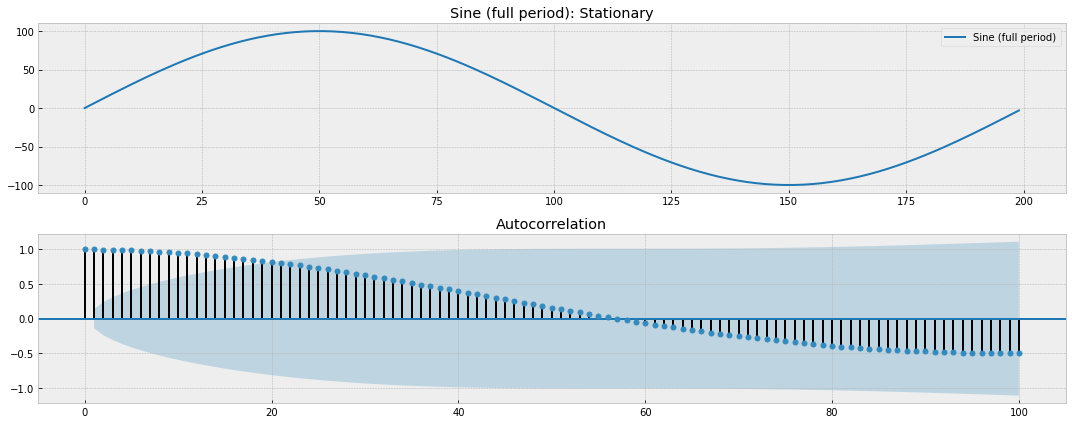

In [260]:
y = generateSine(scale=100)
staplot('Sine (full period)', y)

### Many Periods

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -9.0 < -3.5


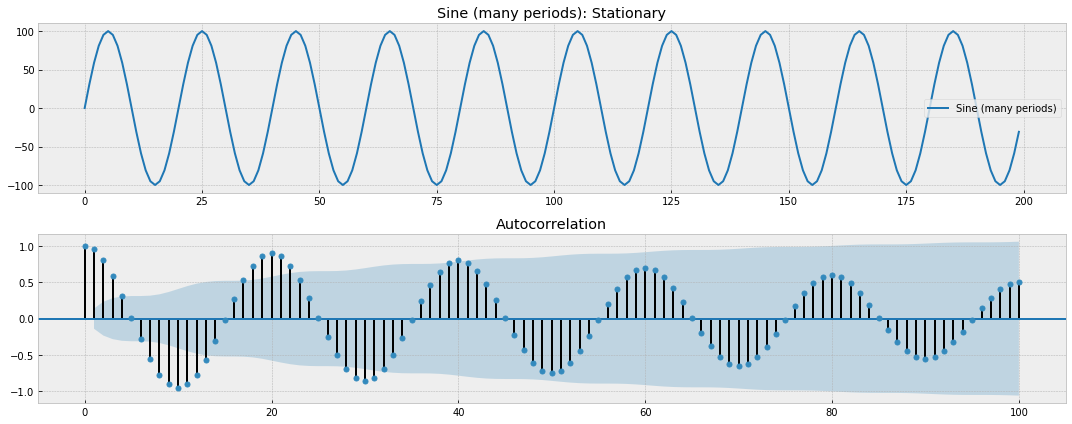

In [226]:
y = generateSine(numPeriods=10, scale=100)
staplot('Sine (many periods)', y)

### Half Period

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -9.5 < -3.5


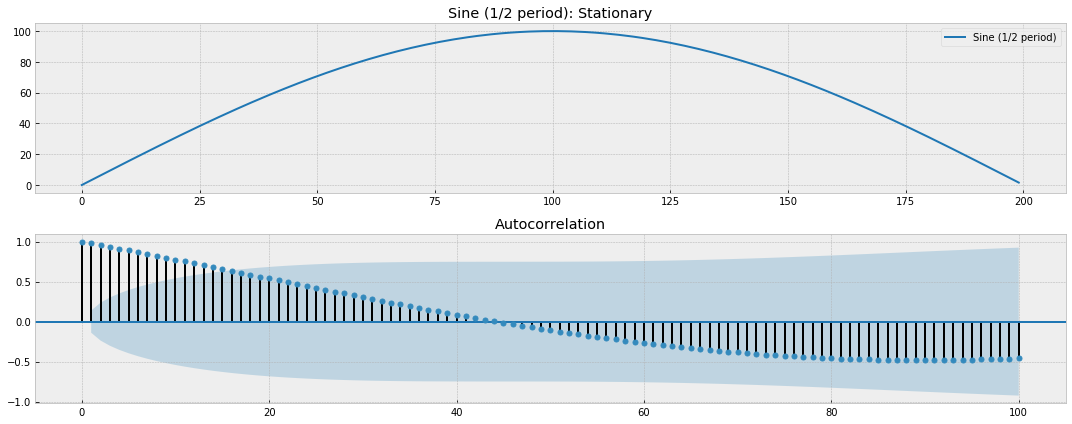

In [227]:
y = generateSine(scale=100, numPeriods=0.5)
staplot('Sine (1/2 period)', y)

### Quarter Period <A name="sine025">

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -8.0 < -3.5


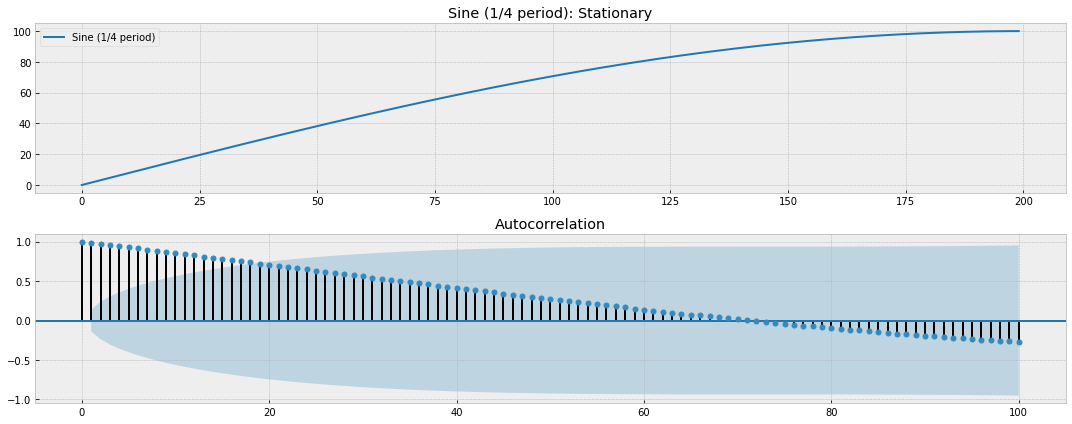

In [243]:
y = generateSine(scale=100, numPeriods=0.25)
staplot('Sine (1/4 period)', y)

What???

Let's try with longer time series.

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -14.6 < -3.4


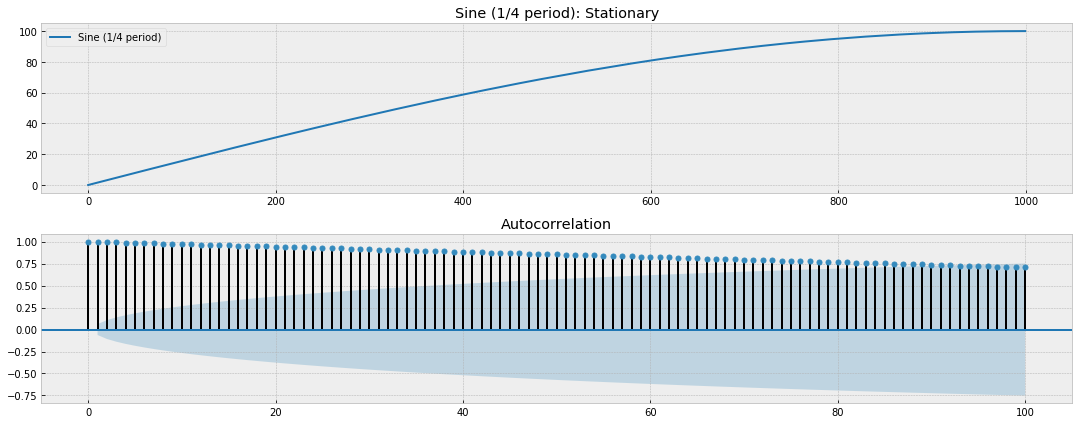

In [229]:
y = generateSine(scale=100, numPeriods=0.25, n=1000)
staplot('Sine (1/4 period)', y)

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -4.9 < -3.4


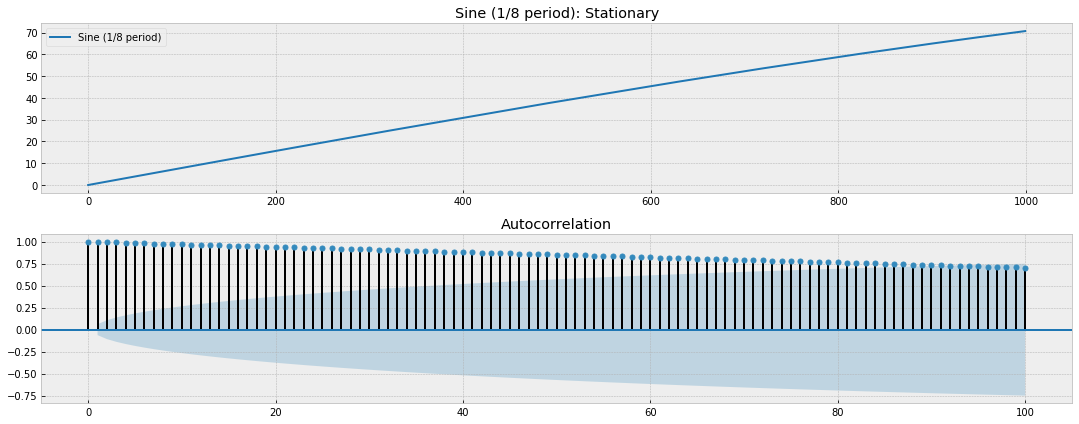

In [230]:
y = generateSine(scale=100, numPeriods=1/8, n=1000)
staplot('Sine (1/8 period)', y)

(Surprise!) It's still stationary even though it looks like a line.

### Quarter Period with Bigger Noise

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -7.9 < -3.4


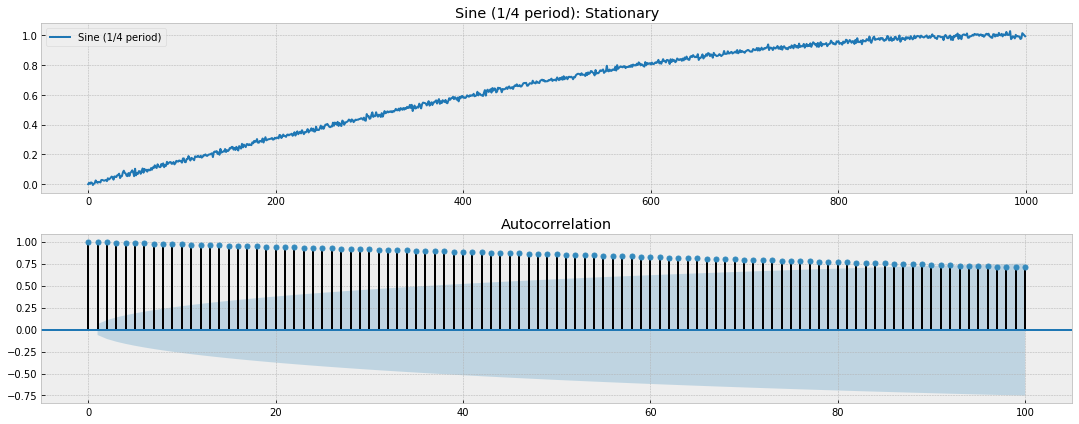

In [231]:
y = generateSine(scale=1, numPeriods=0.25, wscale=0.01, n=1000)
staplot('Sine (1/4 period)', y)

,Decision,Reason
AdFuller,NOT Stationary,pvalue: 0.0830
AdFuller t-value,NOT Stationary,tvalue -2.7 >= -3.4


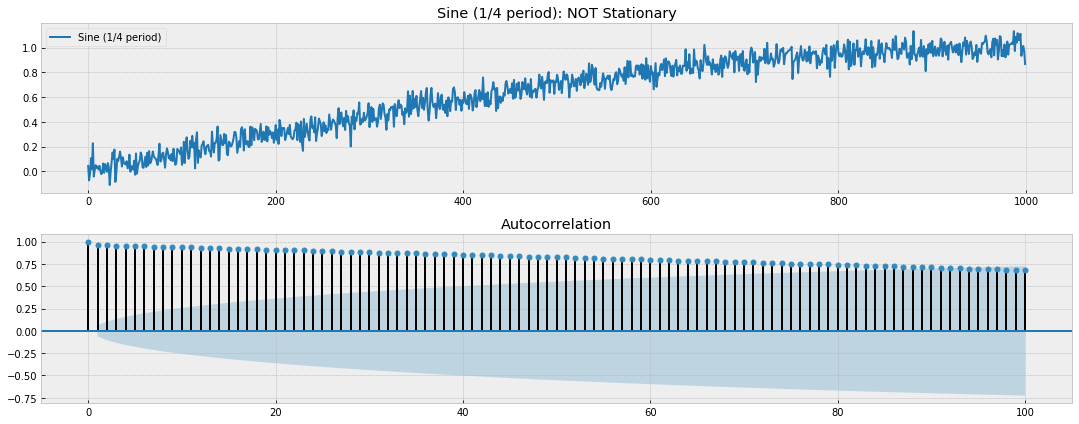

In [232]:
y = generateSine(scale=1, numPeriods=0.25, wscale=0.06, n=1000)
staplot('Sine (1/4 period)', y)

So the noise has some effect to stationarity..

## More Complex Cyclical Waves

In [71]:
def generateCyclical(specs, n=N, wscale=WSCALE):
    w = np.random.normal(scale=wscale, size=n)
    y = np.zeros(n)
    for spec in specs:
        numPeriods = spec.get('numPeriods', 1)
        startPeriod = spec.get('startPeriod', 0)
        scale = spec.get('scale', 1)
        period = n / numPeriods
        x = np.arange(startPeriod, startPeriod+2*np.pi*numPeriods, 2*np.pi/period)
        y += np.sin(x)
    
    return y + w

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -15.1 < -3.5


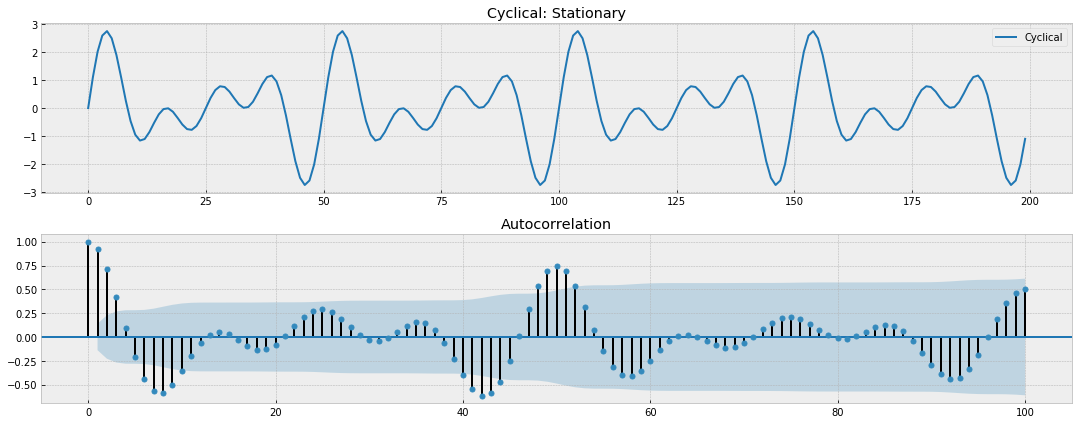

In [233]:
y = generateCyclical([{'numPeriods': 8}, {'numPeriods': 12}, {'numPeriods': 16}])
staplot('Cyclical', y)

,Decision,Reason
AdFuller,Stationary,pvalue: 0.0000
AdFuller t-value,Stationary,tvalue -6.0 < -3.5


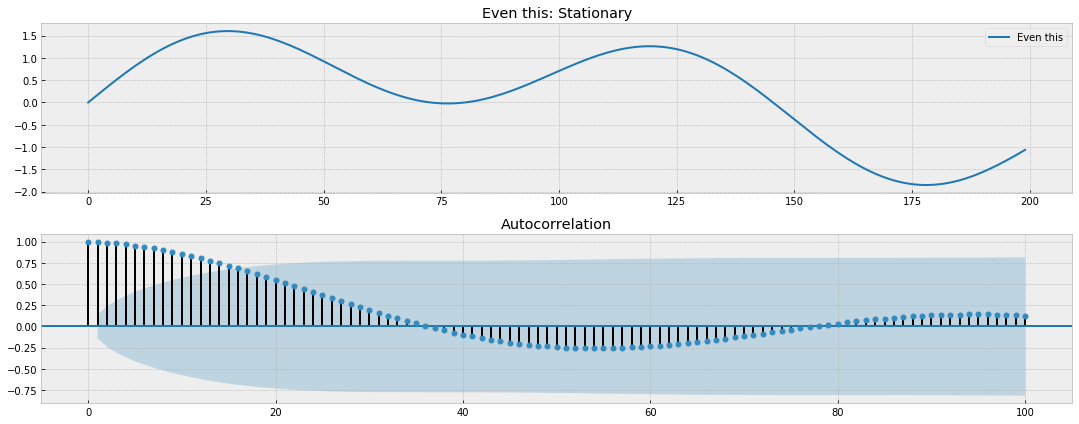

In [234]:
y = generateCyclical([{'numPeriods': 2}, {'numPeriods': 0.75}])
staplot('Even this', y)

# Conclusion

There are few things which I still don't quite get:
- if random walk is not stationary, why [AR(1)](#ar1) with $\rho=0.9$ is (because random walk is essentially AR(1) with $\rho=1$)
- why sine signals are stationary. Especially look at the [quarter period chart above](#sine025), it's clear that the mean is not constant.